In [1]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
sys.path.append(os.path.abspath("../src"))
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from config import RAW_DATA_PATH, RELEVANT_FEATURES, UE_ID_COL
from preprocess import (
    load_and_clean_data,
    get_numerical_features,
    mahalanobis_reconstruction,
    detect_anomalies,convert_to_float
)

Load and preprocess data

In [2]:
df = load_and_clean_data(RAW_DATA_PATH, RELEVANT_FEATURES, UE_ID_COL)
print(df.dtypes)
print(df.head())


X = get_numerical_features(df, RELEVANT_FEATURES)
print(X.dtypes)
print(X.head())
print("Selected numerical features:", X.columns.tolist())
print("Shape of X:", X.shape)
print("Data loaded and cleaned. Shape:", df.shape)

avgLdpcIterations    float64
ulBytes              float64
pmi                   object
rsrp                 float64
cqi                  float64
pucchSnr             float64
rssi                 float64
ueId                   int64
inSync               float64
dlBytes              float64
dlMcs                float64
ulMcs                float64
ulBler               float64
ri                   float64
pcmax                float64
puschSnr             float64
dlBler               float64
phr                  float64
rsrq                 float64
sinr                 float64
dtype: object
   avgLdpcIterations  ulBytes    pmi  rsrp   cqi  pucchSnr  rssi  ueId  \
0                4.1   3768.0  -11,1 -82.0  15.0      21.0  95.0   210   
1                4.5   8921.0  -11,1 -82.0  15.0      27.0  86.0   210   
2                4.3  13420.0  -13,1 -81.0  15.0      24.0  85.7   210   
3                4.5  18274.0  -15,1 -81.0  15.0      27.0  79.7   210   
4                4.7  22916.0  -11,1

Scale

In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_reconstructed = mahalanobis_reconstruction(X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_reconstructed)
print("Shape of PCA-reduced data:", X_pca.shape)


Shape of PCA-reduced data: (13168, 2)


ISE algorithm

In [4]:
def density_score(X, R=1.0):
    n = X.shape[0]
    scores = np.zeros(n)
    for i in range(n):
        for j in range(n):
            if np.linalg.norm(X[i] - X[j]) <= R:
                scores[i] += 1
    return scores

In [5]:
def ise_clustering(X, K=2, R=1.0):
    scores = density_score(X, R)
    centers = []
    used = np.zeros(len(X), dtype=bool)

    for _ in range(K):
        idx = np.argmax(scores * (~used))
        center = X[idx]
        centers.append(center)
        used[np.linalg.norm(X - center, axis=1) < R] = True

    centers = np.array(centers)
    prev_centers = np.zeros_like(centers)

    while not np.allclose(centers, prev_centers):
        clusters = [[] for _ in range(K)]
        for point in X:
            distances = np.linalg.norm(point - centers, axis=1)
            clusters[np.argmin(distances)].append(point)

        prev_centers = centers.copy()
        centers = np.array([np.mean(cluster, axis=0) if cluster else prev for cluster, prev in zip(clusters, centers)])

    labels = np.zeros(len(X), dtype=int)
    for i, point in enumerate(X):
        labels[i] = np.argmin(np.linalg.norm(point - centers, axis=1))

    return labels, centers

ISE clustering 

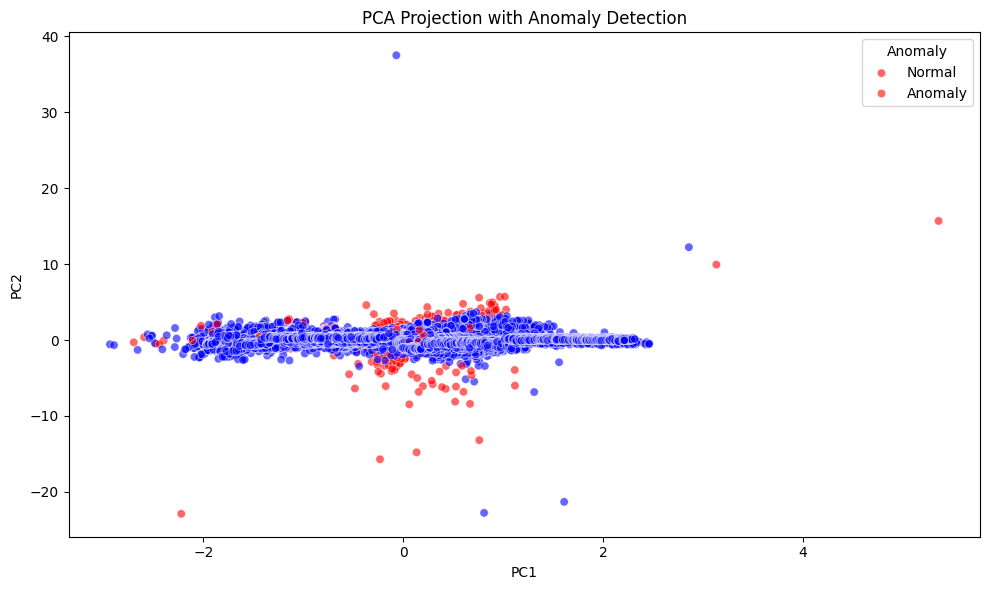

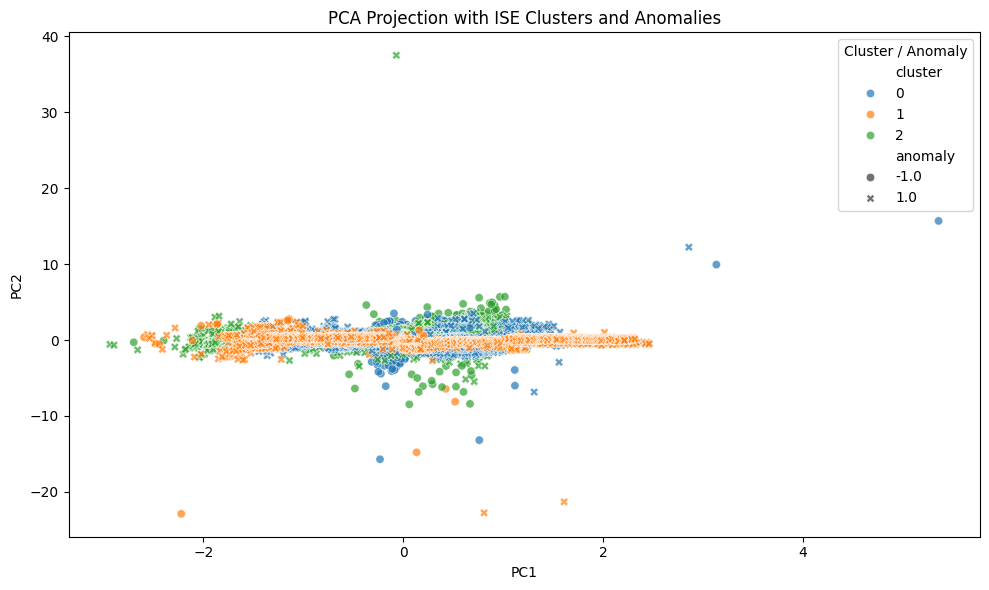

Anomaly ratio per UE ID:
   ueId  anomaly_ratio
0   210       0.096244
1   236       0.003212
Clusters found: [0 1 2]
Cluster centers:
 [[ 0.23944918 -0.11381221  0.04645479  0.30302943 -0.03552743 -0.3662264
  -0.0493853   1.02563227 -0.03088872  0.04910592 -0.08415853  0.01448595
  -0.00718449 -0.01655399 -0.01261845]
 [-0.63085281  0.06032827 -0.12351199 -0.68740581  0.17521031  0.08461361
   0.23398583 -0.47673915 -0.06919984 -0.05425349  0.16484621 -0.04865707
   0.00291504  0.00672965  0.04360731]
 [ 0.77062408  0.09742157  0.15167894  0.76043936 -0.27233248  0.52549506
  -0.36003697 -1.00747366  0.19210682  0.01260678 -0.1607354   0.06693333
   0.0078791   0.01812921 -0.06067215]]
Anomalies detected: 659
Anomaly ratio per UE ID:
   ueId  anomaly_ratio
0   210       0.096244
1   236       0.003212
Script completed successfully.


In [6]:
labels, centers = ise_clustering(X_reconstructed, K=3, R=1.5)
df['cluster'] = labels
df['anomaly'] = detect_anomalies(pd.DataFrame(X_reconstructed))


plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=df['anomaly'], palette={1: 'blue', -1: 'red'}, alpha=0.6
)
plt.title("PCA Projection with Anomaly Detection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['cluster'],
    style=df['anomaly'],
    palette='tab10',
    alpha=0.7
)
plt.title("PCA Projection with ISE Clusters and Anomalies")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Cluster / Anomaly')
plt.tight_layout()
plt.show()



summary = (
    df.groupby(UE_ID_COL)['anomaly']
    .apply(lambda x: (x == -1).sum() / len(x))
    .reset_index(name='anomaly_ratio')
    .sort_values(by='anomaly_ratio', ascending=False)
)
print("Anomaly ratio per UE ID:")
print(summary)
print("Clusters found:", np.unique(labels))
print("Cluster centers:\n", centers)
print("Anomalies detected:", np.sum(df['anomaly'] == -1))
print("Anomaly ratio per UE ID:")
print(summary)
print("Script completed successfully.")

